# Preprocessing and splitting the dataset

## Load the data

In [1]:
import json
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import KFold

In [2]:
data = pd.read_csv('adult.csv')

In [3]:
data.shape

(48842, 15)

In [4]:
data.shape

(48842, 15)

In [5]:
data.replace('?', np.nan, inplace=True)

In [6]:
data.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'fnlwgt'}>,
        <Axes: title={'center': 'education-num'}>],
       [<Axes: title={'center': 'capital-gain'}>,
        <Axes: title={'center': 'capital-loss'}>,
        <Axes: title={'center': 'hours-per-week'}>],
       [<Axes: title={'center': 'income'}>, <Axes: >, <Axes: >]],
      dtype=object)

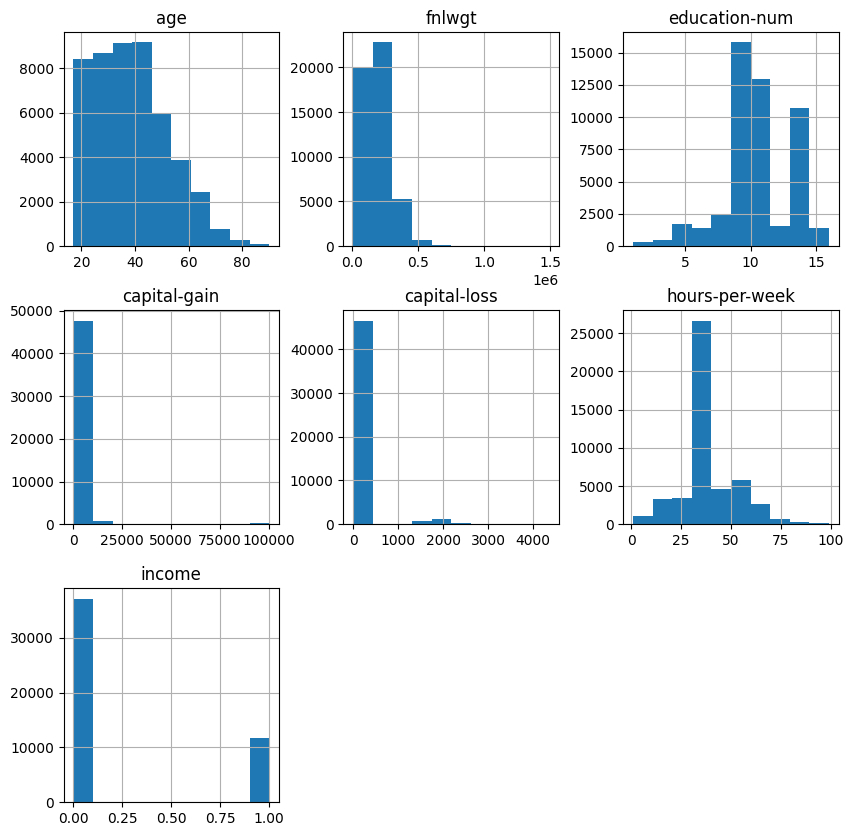

In [7]:
#visualize features
data.hist(figsize=(10, 10))

In [8]:
#value counts for the categorical features: workclass, education, marital-status, occupation, relationship
for feature in ['workclass', 'education', 'marital-status', 'occupation', 'relationship']:
    print('------------ ' + feature + ' ---------------')
    print(data[feature].value_counts())

------------ workclass ---------------
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64
------------ education ---------------
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: education, dtype: int64
------------ marital-status ---------------
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: marital-status, dtype: int64
------

## Encode categorical and ordinal columns

Currently, we encode education as categorical; there's not an obvious way to encode an ordinality for some college vs the two associate's degrees. 

In [9]:
cols_cat = ['workclass', 'education', 'marital-status', 'occupation', 'relationship']

features_cat = data[cols_cat]
features_numerical = data.drop(columns = cols_cat + ['income']).convert_dtypes()

outcome = data['income']

For categorical values in the input features, we use one-hot encoding. We first check that we have no missing data here.

In [10]:
features_cat.isnull().sum()

workclass         2799
education            0
marital-status       0
occupation        2809
relationship         0
dtype: int64

In [11]:
ohe = OneHotEncoder(sparse=False, dtype=int)


In [12]:
cat_array = ohe.fit_transform(features_cat)

/home/users/ham51/.venvs/fastsparsebuild/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
ohe.get_feature_names_out()

array(['workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Without-pay', 'workclass_nan',
       'education_10th', 'education_11th', 'education_12th',
       'education_1st-4th', 'education_5th-6th', 'education_7th-8th',
       'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc',
       'education_Bachelors', 'education_Doctorate', 'education_HS-grad',
       'education_Masters', 'education_Preschool',
       'education_Prof-school', 'education_Some-college',
       'marital-status_Divorced', 'marital-status_Married-AF-spouse',
       'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent',
       'marital-status_Never-married', 'marital-status_Separated',
       'marital-status_Widowed', 'occupation_Adm-clerical',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occupation_Exe

In [14]:
ohe = OneHotEncoder(sparse=False, dtype=int)
cat_array = ohe.fit_transform(features_cat)
feature_labels = ohe.get_feature_names_out()
features_cat_onehot = pd.DataFrame(cat_array, columns=feature_labels)

/home/users/ham51/.venvs/fastsparsebuild/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
features_cat_onehot

,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,workclass_nan,education_10th,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,occupation_nan,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
48838,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
48839,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
48840,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


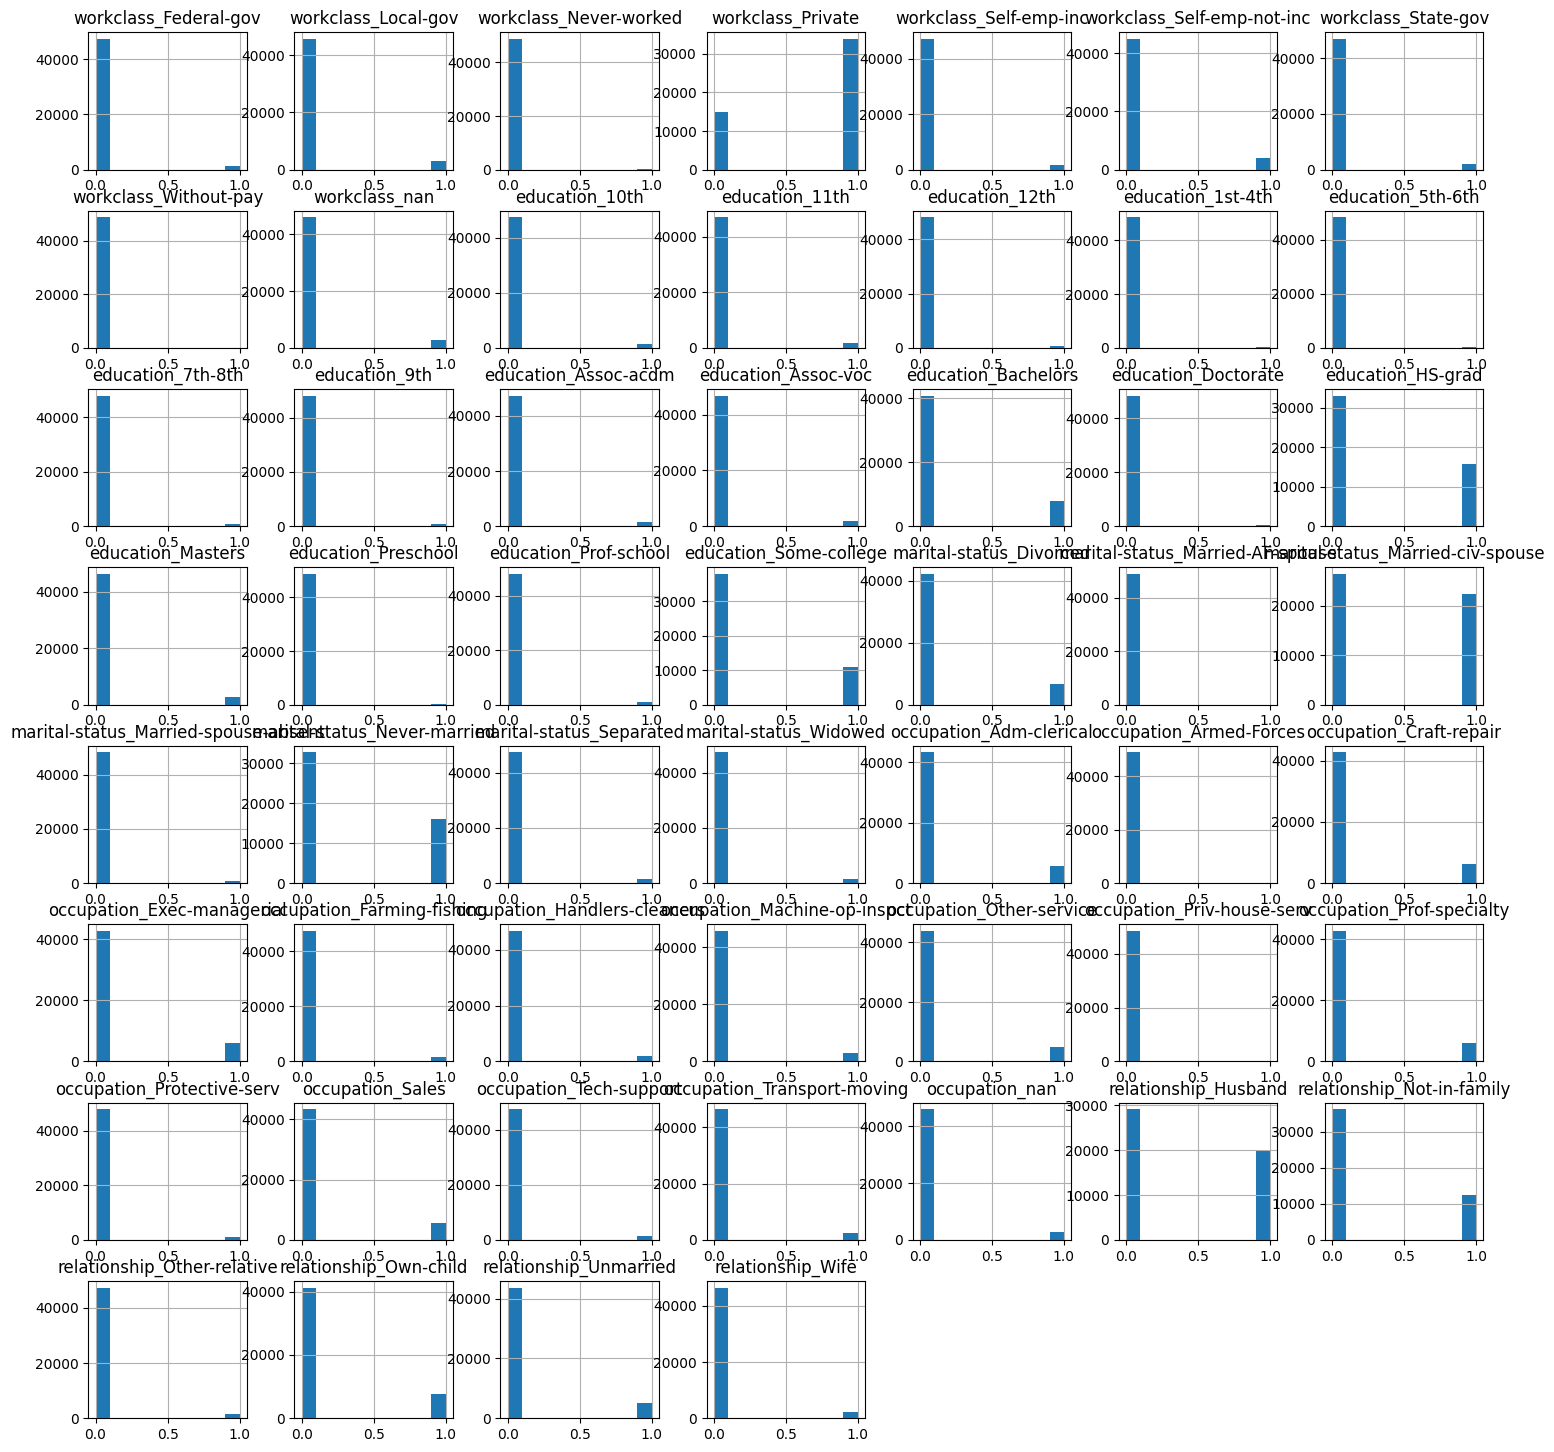

In [16]:
features_cat_onehot.hist(figsize=(18, 18));

In [17]:
nan_indicators = features_cat_onehot.columns[features_cat_onehot.columns.str.contains('nan')]

In [30]:
for indicator in nan_indicators: 
    feature = indicator.split('_nan')[0]
    other_indicators = features_cat_onehot.columns[features_cat_onehot.columns.str.contains(feature)]
    missing_mask = features_cat_onehot[indicator] == 1
    features_cat_onehot.loc[missing_mask,other_indicators] = np.nan

In [35]:
#TODO: verify - would imputation drop these indicators, or keep them in addition? 
for indicator in nan_indicators: 
    features_cat_onehot.drop(columns=indicator, inplace=True)

In [ ]:
data.head()

### Collect into a single DataFrame

In [31]:
df_onehot = pd.concat([features_cat_onehot, outcome], axis=1)

features = features_numerical.join([features_cat])
df = pd.concat([features, outcome], axis=1)

In [32]:
df

,age,fnlwgt,education-num,race,sex,capital-gain,capital-loss,hours-per-week,native-country,workclass,education,marital-status,occupation,relationship,income
0,39,77516,13,White,Male,2174,0,40,United-States,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,0
1,50,83311,13,White,Male,0,0,13,United-States,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,0
2,38,215646,9,White,Male,0,0,40,United-States,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,0
3,53,234721,7,Black,Male,0,0,40,United-States,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,0
4,28,338409,13,Black,Female,0,0,40,Cuba,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,215419,13,White,Female,0,0,36,United-States,Private,Bachelors,Divorced,Prof-specialty,Not-in-family,0
48838,64,321403,9,Black,Male,0,0,40,United-States,NaN,HS-grad,Widowed,NaN,Other-relative,0
48839,38,374983,13,White,Male,0,0,50,United-States,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,0
48840,44,83891,13,Asian-Pac-Islander,Male,5455,0,40,United-States,Private,Bachelors,Divorced,Adm-clerical,Own-child,0


In [34]:
df_onehot

,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,workclass_nan,education_10th,...,occupation_Tech-support,occupation_Transport-moving,occupation_nan,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,income
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,...,0.0,0.0,0.0,0,1,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,1,0,0,0,0,0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,1,0,0,0,0,0
48838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,0,0,1,0,0,0,0
48839,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
48840,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0,0,1,0,0,0


Some of the code requires encoding the categorical columns (factors) with numerical levels. To ensure consistency, we save a list of all the levels of these columns.

In [27]:
levels = [(col, sorted(df[col].unique())) for col in sorted(cols_cat)]
with open("factor_levels.json", "w", encoding="UTF-8") as levelsfile:
    json.dump(levels, levelsfile)

Some of the imputation code requires knowing which columns are categorical and ordinal, so we store this information.  We now include yes/no (or similar) columns in the list of categorical columns.

One of the imputation methods (MissForest) required encoding the one-hot columns as a single ordinal column; we also determine the column numbers of the categorical and ordinal columns for this encoded version.  For this purpose, we use a standalone variant of the `onehot_to_ord_multicat` method from `data_loader.py` that just returns the columns in the encoded version.  It does more than strictly needed, but that is to ensure it behaves as the `data_loader.py` method does.  Furthermore, the imputation methods only see the non-outcome columns, so we remove the outcome column before performing the encoding.

In [28]:
def get_encoders(factor_levels):
    # factor_levels should be the `levels` variable created above
    factors = [fl[0] for fl in factor_levels]
    levels = [fl[1] for fl in factor_levels]

    # sklearn requires us to fit a non-empty DataFrame even if we specify all
    # the levels
    dummy_df = pd.DataFrame({fl[0]: [fl[1][0]] for fl in factor_levels})
    cat_colnames = factors
    # building the model for transformations
    ohe = OneHotEncoder(categories=levels, sparse=False)
    onehot_encoder = ohe.fit(dummy_df)
    encoded_colnames = ohe.get_feature_names_out(factors)
    # building LabelEncoder dictionary model
    orde = OrdinalEncoder(categories=levels)
    ordinal_encoder = orde.fit(dummy_df)

    return {
        "cat_colnames": cat_colnames,
        "onehot_encoder": onehot_encoder,
        "encoded_colnames": encoded_colnames,
        "ordinal_encoder": ordinal_encoder,
    }


def onehot_to_ord_columns(df, factor_levels):
    encoders = get_encoders(factor_levels)
    onehot_encoder = encoders["onehot_encoder"]
    ordinal_encoder = encoders["ordinal_encoder"]
    encoded_colnames = encoders["encoded_colnames"]
    cat_colnames = encoders["cat_colnames"]

    onehot_df = df[encoded_colnames]
    oh_decoded = onehot_encoder.inverse_transform(onehot_df)
    # silence warning in ordinal_encoder.transform
    oh_decoded_df = pd.DataFrame(oh_decoded, columns=cat_colnames, index=df.index)
    ord_df = ordinal_encoder.transform(oh_decoded_df)
    ord_df = pd.DataFrame(ord_df, columns=cat_colnames, index=df.index)
    rest_df = df.drop(encoded_colnames, axis=1)
    converted_df = pd.concat([rest_df, ord_df], axis=1)
    return list(converted_df.columns)

In [29]:
cols_cat = [
    "Oncotree Code",
    "Overall Patient Receptor Status",
    "ER Status of the Primary",
    "Metastatic Disease at Last Follow-up",
    "M Stage",
    "Overall Patient HER2 Status",
    "Overall Patient HR Status",
    "PR Status of the Primary",
]
cols_ord = [
    "N Stage",
    "Overall Primary Tumor Grade",
    "Stage At Diagnosis",
    "T Stage",
]

breast_df_onehot_no_outcome = breast_df_onehot.drop(columns=cols_outcome_cat)

idxs = {}

columns = list(breast_df_onehot_no_outcome.columns)
idx_cat = []
for idx, col in enumerate(columns):
    for cat in cols_cat:
        if col.startswith(cat):
            idx_cat.append(idx)
idx_ord = [columns.index(col) for col in cols_ord]
idxs["onehot"] = [idx_cat, idx_ord]

encoded_cols = onehot_to_ord_columns(breast_df_onehot_no_outcome, levels)
idx_cat = [encoded_cols.index(col) for col in cols_cat]
idx_ord = [encoded_cols.index(col) for col in cols_ord]
idxs["encoded"] = [idx_cat, idx_ord]

idxs["colnames"] = {"onehot": columns, "encoded": encoded_cols}

In [30]:
with open("Breast_cancer_cols.json", "w", encoding="UTF-8") as colsfile:
    json.dump(idxs, colsfile)

We also save the complete resulting dataset for later use.

In [31]:
breast_df.to_csv("Breast_cancer_complete_used.csv", index=False)
breast_df_onehot.to_csv("Breast_cancer_complete_used_onehot.csv", index=False)

### Create training, validation and holdout sets

We use the one-hot encoded data to create the standard datasets.

In [32]:
outdir = Path('.')
outdir.mkdir(exist_ok=True)

n_splits = 10
n_folds = 5
idx = np.arange(len(breast_df))

kf_splits = KFold(n_splits=n_splits, random_state=1896, shuffle=True)

for holdout_num, out_split in enumerate(kf_splits.split(idx)):
    idx_train = idx[out_split[0]]
    idx_test = idx[out_split[1]]
    devel_fold = breast_df_onehot.iloc[idx_train, ]
    test_fold = breast_df_onehot.iloc[idx_test, ]

    # Check that we haven't got any duplicates
    temp = pd.concat([devel_fold, test_fold])
    assert temp.duplicated().sum() == 0

    test_fold.to_csv(outdir / f'holdout_{holdout_num}.csv', index=False)

    kf_folds = KFold(n_splits=n_folds, random_state=165782 * holdout_num, shuffle=True)
    idx_folds = np.arange(len(devel_fold))
    for fold_num, idx_fold_split in enumerate(kf_folds.split(idx_folds)):
        train_fold = devel_fold.iloc[idx_fold_split[0]]
        val_fold = devel_fold.iloc[idx_fold_split[1]]
        train_fold.to_csv(outdir / f'devel_{holdout_num}_train_{fold_num}.csv', index=False)
        val_fold.to_csv(outdir / f'devel_{holdout_num}_val_{fold_num}.csv', index=False)